In [1]:
import sys
sys.path.append("../../src")
import torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torch.nn.functional as F

import glob
import os
from datetime import datetime
import time
import math
from tqdm import tqdm

from itertools import repeat
from torch.nn.parameter import Parameter
import collections
import matplotlib
from torch_utils import *
from ContrastiveModels import ContrastiveCorInfoMaxHopfieldSparse
from visualization import *
# matplotlib.use('Agg')

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), 
                                            torchvision.transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), 
                                            std=(3*0.2023, 3*0.1994, 3*0.2010))])

cifar_dset_train = torchvision.datasets.CIFAR10('../../data', train=True, transform=transform, target_transform=None, download=True)
train_loader = torch.utils.data.DataLoader(cifar_dset_train, batch_size=20, shuffle=True, num_workers=0)

cifar_dset_test = torchvision.datasets.CIFAR10('../../data', train=False, transform=transform, target_transform=None, download=True)
test_loader = torch.utils.data.DataLoader(cifar_dset_test, batch_size=20, shuffle=False, num_workers=0)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
activation = hard_sigmoid
architecture = architecture = [int(32*32*3), 1000, 10]

beta = 1
lambda_ = 0.99999
epsilon = 0.15
one_over_epsilon = 1 / epsilon
lr_start = {'ff': np.array([0.09, 0.07]), 'fb': np.array([ np.nan, 0.045])}

STlambda_lr_list = [1*1e-5, 0.01]
sparse_layers = [1, 2]
neural_lr_start = 0.025
neural_lr_stop = 0.001
neural_lr_rule = "divide_by_slow_loop_index"
neural_lr_decay_multiplier = 0.01
neural_dynamic_iterations_nudged = 10
neural_dynamic_iterations_free = 30
hopfield_g = 0.1
use_random_sign_beta = True
use_three_phase = False
weight_decay = False

model = ContrastiveCorInfoMaxHopfieldSparse(architecture = architecture, lambda_ = lambda_, 
                                            epsilon = epsilon, activation = activation, 
                                            sparse_layers = sparse_layers)

In [5]:
_ = evaluateContrastiveCorInfoMaxHopfieldSparse(model, train_loader, hopfield_g,
                                                neural_lr_start, neural_lr_stop, STlambda_lr_list, neural_lr_rule, 
                                                neural_lr_decay_multiplier, neural_dynamic_iterations_free, device)

Train accuracy :	 0.15244


In [6]:
trn_acc_list = []
tst_acc_list = []

n_epochs = 30

for epoch_ in range(n_epochs):
    if epoch_ < 15:
        lr = {'ff' : lr_start['ff'] * (0.95)**epoch_, 'fb' : lr_start['fb'] * (0.95)**epoch_}
    else:
        lr = {'ff' : lr_start['ff'] * (0.9)**epoch_, 'fb' : lr_start['fb'] * (0.9)**epoch_}
    for idx, (x, y) in tqdm(enumerate(train_loader)):
        x, y = x.to(device), y.to(device)
        x = x.view(x.size(0),-1).T
        y_one_hot = F.one_hot(y, 10).to(device).T
        take_debug_logs_ = (idx % 500 == 0)
        if use_random_sign_beta:
            rnd_sgn = 2*np.random.randint(2) - 1
            beta = rnd_sgn*beta
            
        neurons = model.batch_step_hopfield( x, y_one_hot, hopfield_g, 
                                             lr, neural_lr_start, neural_lr_stop, STlambda_lr_list, neural_lr_rule, 
                                             neural_lr_decay_multiplier, neural_dynamic_iterations_free,
                                             neural_dynamic_iterations_nudged, beta, 
                                             use_three_phase, take_debug_logs_, weight_decay)
    
    trn_acc = evaluateContrastiveCorInfoMaxHopfieldSparse(  model, train_loader, hopfield_g, neural_lr_start, 
                                                            neural_lr_stop, STlambda_lr_list, neural_lr_rule, 
                                                            neural_lr_decay_multiplier, 
                                                            neural_dynamic_iterations_free, 
                                                            device, printing = False)
    tst_acc = evaluateContrastiveCorInfoMaxHopfieldSparse(  model, test_loader, hopfield_g, neural_lr_start, 
                                                            neural_lr_stop, STlambda_lr_list, neural_lr_rule, 
                                                            neural_lr_decay_multiplier, 
                                                            neural_dynamic_iterations_free, 
                                                            device, printing = False)
    trn_acc_list.append(trn_acc)
    tst_acc_list.append(tst_acc)
    
    print("Epoch : {}, Train Accuracy : {}, Test Accuracy : {}".format(epoch_+1, trn_acc, tst_acc))
    print("Free Information ratio: {}".format(np.array(model.layerwise_forward_corinfo_list_free)[-1] / np.array(model.layerwise_backward_corinfo_list_free)[-1]))
    print("Nudged Information ratio: {}".format(np.array(model.layerwise_forward_corinfo_list_nudged)[-1] / np.array(model.layerwise_backward_corinfo_list_nudged)[-1]))

2500it [01:13, 33.80it/s]
0it [00:00, ?it/s]

Epoch : 1, Train Accuracy : 0.37218, Test Accuracy : 0.37
Free Information ratio: [0.00968893]
Nudged Information ratio: [0.0096884]


2500it [01:13, 33.81it/s]
0it [00:00, ?it/s]

Epoch : 2, Train Accuracy : 0.42386, Test Accuracy : 0.4177
Free Information ratio: [0.01130907]
Nudged Information ratio: [0.01130798]


2500it [01:13, 33.81it/s]
0it [00:00, ?it/s]

Epoch : 3, Train Accuracy : 0.43744, Test Accuracy : 0.4276
Free Information ratio: [0.00624719]
Nudged Information ratio: [0.00624667]


2500it [01:13, 33.82it/s]
0it [00:00, ?it/s]

Epoch : 4, Train Accuracy : 0.46732, Test Accuracy : 0.446
Free Information ratio: [0.00917451]
Nudged Information ratio: [0.0091729]


2500it [01:14, 33.58it/s]
0it [00:00, ?it/s]

Epoch : 5, Train Accuracy : 0.4889, Test Accuracy : 0.4624
Free Information ratio: [0.0092542]
Nudged Information ratio: [0.00925242]


2500it [01:13, 33.82it/s]
0it [00:00, ?it/s]

Epoch : 6, Train Accuracy : 0.50362, Test Accuracy : 0.4676
Free Information ratio: [0.00955776]
Nudged Information ratio: [0.00955579]


2500it [01:14, 33.77it/s]
0it [00:00, ?it/s]

Epoch : 7, Train Accuracy : 0.5159, Test Accuracy : 0.4723
Free Information ratio: [0.01104309]
Nudged Information ratio: [0.01103886]


2500it [01:14, 33.77it/s]
0it [00:00, ?it/s]

Epoch : 8, Train Accuracy : 0.53348, Test Accuracy : 0.4845
Free Information ratio: [0.01379732]
Nudged Information ratio: [0.01379194]


2500it [01:14, 33.77it/s]
0it [00:00, ?it/s]

Epoch : 9, Train Accuracy : 0.53844, Test Accuracy : 0.4829
Free Information ratio: [0.01834714]
Nudged Information ratio: [0.01834175]


2500it [01:14, 33.78it/s]
0it [00:00, ?it/s]

Epoch : 10, Train Accuracy : 0.55396, Test Accuracy : 0.4937
Free Information ratio: [0.01509931]
Nudged Information ratio: [0.01509225]


2500it [01:14, 33.77it/s]
0it [00:00, ?it/s]

Epoch : 11, Train Accuracy : 0.56028, Test Accuracy : 0.4963
Free Information ratio: [0.01426013]
Nudged Information ratio: [0.01425374]


2500it [01:14, 33.78it/s]
0it [00:00, ?it/s]

Epoch : 12, Train Accuracy : 0.56966, Test Accuracy : 0.4977
Free Information ratio: [0.01399024]
Nudged Information ratio: [0.01398203]


2500it [01:13, 33.79it/s]
0it [00:00, ?it/s]

Epoch : 13, Train Accuracy : 0.57698, Test Accuracy : 0.4988
Free Information ratio: [0.01359743]
Nudged Information ratio: [0.01359038]


2500it [01:13, 33.79it/s]
0it [00:00, ?it/s]

Epoch : 14, Train Accuracy : 0.5867, Test Accuracy : 0.5035
Free Information ratio: [0.01225341]
Nudged Information ratio: [0.01224654]


2500it [01:14, 33.77it/s]
0it [00:00, ?it/s]

Epoch : 15, Train Accuracy : 0.59134, Test Accuracy : 0.5029
Free Information ratio: [0.01607685]
Nudged Information ratio: [0.01606824]


2500it [01:15, 32.90it/s]
0it [00:00, ?it/s]

Epoch : 16, Train Accuracy : 0.598, Test Accuracy : 0.5016
Free Information ratio: [0.0121256]
Nudged Information ratio: [0.01211737]


2500it [02:16, 18.31it/s]
0it [00:00, ?it/s]

Epoch : 17, Train Accuracy : 0.60496, Test Accuracy : 0.5101
Free Information ratio: [0.01315991]
Nudged Information ratio: [0.01315041]


2500it [02:17, 18.23it/s]
0it [00:00, ?it/s]

Epoch : 18, Train Accuracy : 0.60896, Test Accuracy : 0.5059
Free Information ratio: [0.010439]
Nudged Information ratio: [0.01042898]


2500it [02:15, 18.39it/s]
0it [00:00, ?it/s]

Epoch : 19, Train Accuracy : 0.60916, Test Accuracy : 0.5083
Free Information ratio: [0.01507114]
Nudged Information ratio: [0.01506173]


2500it [02:15, 18.39it/s]
0it [00:00, ?it/s]

Epoch : 20, Train Accuracy : 0.61386, Test Accuracy : 0.5099
Free Information ratio: [0.0102774]
Nudged Information ratio: [0.01026624]


2500it [02:16, 18.27it/s]
0it [00:00, ?it/s]

Epoch : 21, Train Accuracy : 0.61418, Test Accuracy : 0.5081
Free Information ratio: [0.01116454]
Nudged Information ratio: [0.01115267]


2500it [02:16, 18.29it/s]
0it [00:00, ?it/s]

Epoch : 22, Train Accuracy : 0.61866, Test Accuracy : 0.5106
Free Information ratio: [0.01436529]
Nudged Information ratio: [0.01435241]


2500it [02:16, 18.34it/s]
0it [00:00, ?it/s]

Epoch : 23, Train Accuracy : 0.61868, Test Accuracy : 0.51
Free Information ratio: [0.01109402]
Nudged Information ratio: [0.01108446]


2500it [01:48, 22.94it/s]
0it [00:00, ?it/s]

Epoch : 24, Train Accuracy : 0.61992, Test Accuracy : 0.5091
Free Information ratio: [0.01354191]
Nudged Information ratio: [0.01352971]


2500it [02:16, 18.37it/s]
0it [00:00, ?it/s]

Epoch : 25, Train Accuracy : 0.61914, Test Accuracy : 0.511
Free Information ratio: [0.01090455]
Nudged Information ratio: [0.01089015]


2500it [02:17, 18.19it/s]
0it [00:00, ?it/s]

Epoch : 26, Train Accuracy : 0.62276, Test Accuracy : 0.51
Free Information ratio: [0.01270252]
Nudged Information ratio: [0.01268951]


2500it [02:15, 18.41it/s]
0it [00:00, ?it/s]

Epoch : 27, Train Accuracy : 0.62276, Test Accuracy : 0.5128
Free Information ratio: [0.01154183]
Nudged Information ratio: [0.01152829]


2500it [02:17, 18.23it/s]
0it [00:00, ?it/s]

Epoch : 28, Train Accuracy : 0.62432, Test Accuracy : 0.5106
Free Information ratio: [0.01256036]
Nudged Information ratio: [0.01254681]


2500it [02:16, 18.32it/s]
0it [00:00, ?it/s]

Epoch : 29, Train Accuracy : 0.62462, Test Accuracy : 0.511
Free Information ratio: [0.01080284]
Nudged Information ratio: [0.01078981]


2500it [02:15, 18.39it/s]


Epoch : 30, Train Accuracy : 0.62516, Test Accuracy : 0.5116
Free Information ratio: [0.00989662]
Nudged Information ratio: [0.00988179]


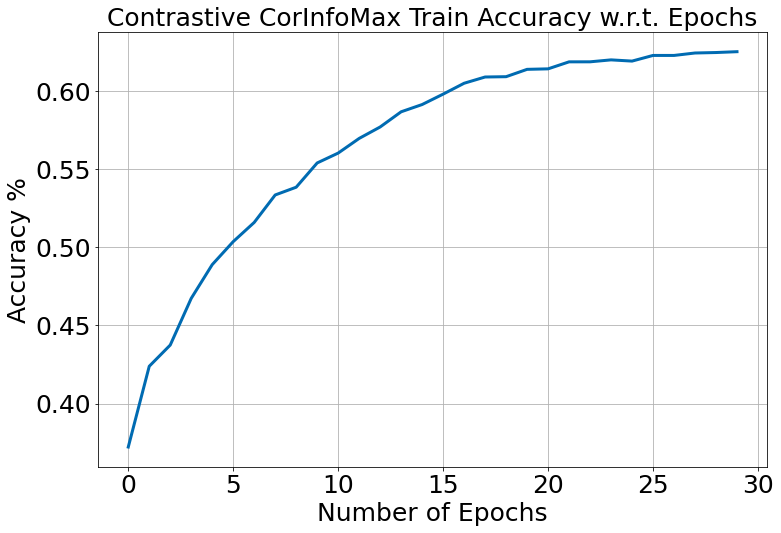

In [7]:
plot_convergence_plot(trn_acc_list, xlabel = 'Number of Epochs', ylabel = 'Accuracy %',
                      title = 'Contrastive CorInfoMax Train Accuracy w.r.t. Epochs', 
                      figsize = (12,8), fontsize = 25, linewidth = 3)

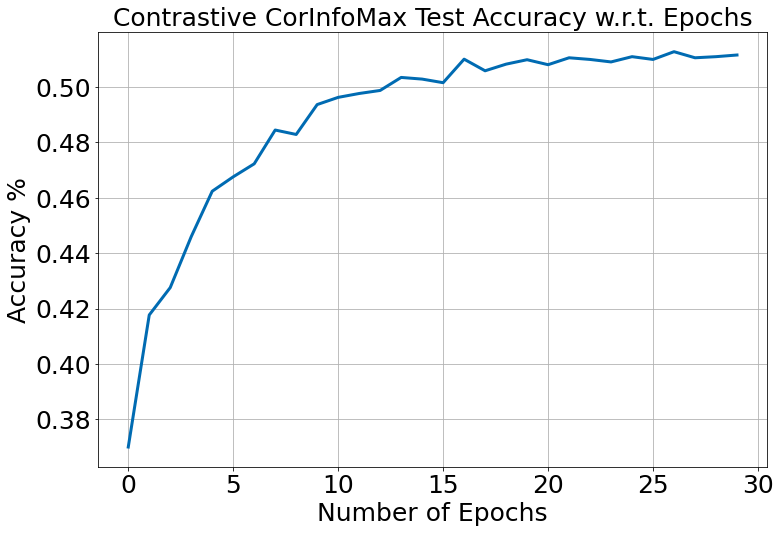

In [8]:
plot_convergence_plot(tst_acc_list, xlabel = 'Number of Epochs', ylabel = 'Accuracy %',
                      title = 'Contrastive CorInfoMax Test Accuracy w.r.t. Epochs', 
                      figsize = (12,8), fontsize = 25, linewidth = 3)